In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# Load in the data and set the month column as the index, hopefully this looks familiar
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df.index = df["Month"]
df = df.drop(columns=["Month"])
df

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


<Axes: xlabel='Month'>

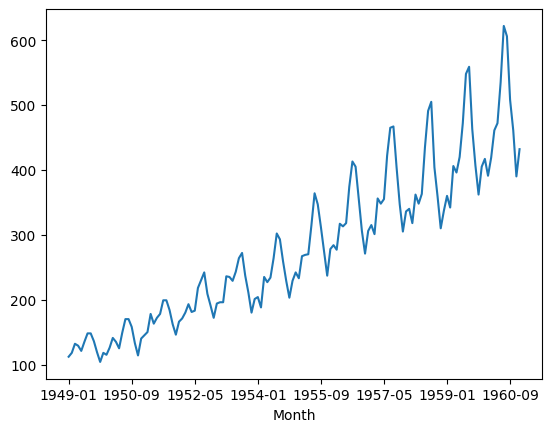

In [ ]:
df["Passengers"].plot()

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(7)

As we are only working with one input, we extract the data from the dataframe and store it as a numpy array, so it works well with tensorflow.

In [ ]:
dataset = df.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. You can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

After you model the data and estimate the skill of your model on the training dataset, you need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, you would do this using cross validation.

With time series data, the sequence of values is important. A simple method that you can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets, with 67% of the observations used to train the model, leaving the remaining 33% for testing the model.

In [ ]:
# split into train and test sets
train_size = int(len(normalized_dataset) * 0.67)
test_size = len(normalized_dataset) - train_size
train, test = normalized_dataset[0:train_size,:], normalized_dataset[train_size:len(normalized_dataset),:]
print(len(train), len(test))

96 48


Now, you can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array you want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period—in this case, defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t), and Y is the number of passengers at the next time (t + 1).

It can be configured by constructing a differently shaped dataset in the next section.

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [ ]:
dataX, dataY = create_dataset(dataset)
print(dataX[:5], dataY[:5])

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]] [118. 132. 129. 121. 135.]


Let’s use this function to prepare the train and test datasets for modeling.

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of *[samples, time steps, features]*.

Currently, the data is in the form of *[samples, features]*, and you are framing the problem as one time step for each sample. You can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX)

[[[0.01544401]]

 [[0.02702703]]

 [[0.05405405]]

 [[0.04826255]]

 [[0.03281853]]

 [[0.05984557]]

 [[0.08494207]]

 [[0.08494207]]

 [[0.06177607]]

 [[0.02895753]]

 [[0.        ]]

 [[0.02702703]]

 [[0.02123553]]

 [[0.04247104]]

 [[0.07142857]]

 [[0.05984557]]

 [[0.04054055]]

 [[0.08687258]]

 [[0.12741312]]

 [[0.12741312]]

 [[0.10424709]]

 [[0.05598456]]

 [[0.01930502]]

 [[0.06949806]]

 [[0.07915059]]

 [[0.08880308]]

 [[0.14285713]]

 [[0.11389962]]

 [[0.13127413]]

 [[0.14285713]]

 [[0.18339768]]

 [[0.18339768]]

 [[0.15444016]]

 [[0.11196911]]

 [[0.08108109]]

 [[0.1196911 ]]

 [[0.12934363]]

 [[0.14671814]]

 [[0.17181468]]

 [[0.14864865]]

 [[0.15250966]]

 [[0.22007722]]

 [[0.24324325]]

 [[0.26640925]]

 [[0.2027027 ]]

 [[0.16795367]]

 [[0.13127413]]

 [[0.17374519]]

 [[0.17760617]]

 [[0.17760617]]

 [[0.25482625]]

 [[0.25289574]]

 [[0.24131274]]

 [[0.26833975]]

 [[0.3088803 ]]

 [[0.32432434]]

 [[0.25675675]]

 [[0.20656371]]

 [[0.14671814]

You are now ready to design and fit your LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs, and a batch size of 1 is used.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0489 - 2s/epoch - 26ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0242 - 212ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0172 - 194ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0155 - 192ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0144 - 209ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0132 - 185ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0122 - 178ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0111 - 188ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0102 - 186ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0090 - 200ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0081 - 177ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0070 - 180ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0062 - 187ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0054 - 191ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0046 - 185ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0040 - 202ms/epoc

Once the model is fit, you can estimate the performance of the model on the train and test datasets. This will give you a point of comparison for new models.

Note that you will invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 7ms/step
Train Score: 22.68 RMSE
Test Score: 49.66 RMSE


Finally, you can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, you must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

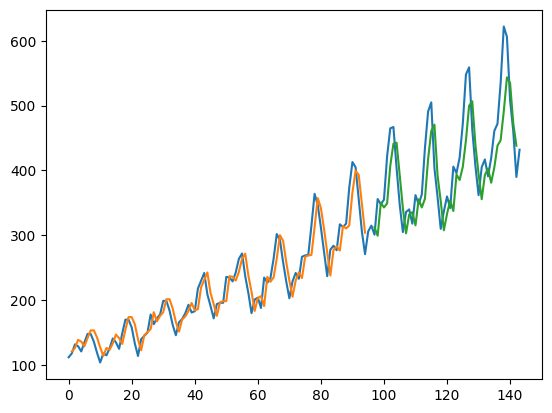

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(normalized_dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

I'm going to wrap some of the above code in functions so we can play around a bit more.

In [ ]:
def normalize_dataset(dataset):
  scaler = MinMaxScaler(feature_range=(0, 1))
  normalized_dataset = scaler.fit_transform(dataset)
  return normalized_dataset

def test_train_split(normalized_dataset, test_perc):
  # split into train and test sets
  train_size = int(len(normalized_dataset) * test_perc)
  test_size = len(normalized_dataset) - train_size
  train, test = normalized_dataset[0:train_size,:], normalized_dataset[train_size:len(normalized_dataset),:]
  return train, test

def create_train_test(train, test, look_back=1):
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  return trainX, testX, trainY, testY

def reshape_train_test(trainX, testX):
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  return trainX, testX

def get_train_test_from_data(dataset, look_back=1, test_perc=0.67):
  normalized_dataset = normalize_dataset(dataset)
  train, test = test_train_split(normalized_dataset, test_perc)
  trainX, testX, trainY, testY = create_train_test(train, test, look_back)
  trainX, testX = reshape_train_test(trainX, testX)
  return trainX, testX, trainY, testY


def evaluate(model, trainX, testX, trainY, testY):
  # make predictions
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  return trainPredict, testPredict

def plot_results(model, dataset, trainPredict, testPredict):
  normalized_dataset = normalize_dataset(dataset)
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(normalized_dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(normalized_dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(normalized_dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(dataset)
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()

Our flow now looks like this

Epoch 1/100
90/90 - 6s - loss: 0.0462 - 6s/epoch - 64ms/step
Epoch 2/100
90/90 - 0s - loss: 0.0215 - 334ms/epoch - 4ms/step
Epoch 3/100
90/90 - 0s - loss: 0.0164 - 352ms/epoch - 4ms/step
Epoch 4/100
90/90 - 0s - loss: 0.0150 - 332ms/epoch - 4ms/step
Epoch 5/100
90/90 - 0s - loss: 0.0134 - 346ms/epoch - 4ms/step
Epoch 6/100
90/90 - 0s - loss: 0.0112 - 338ms/epoch - 4ms/step
Epoch 7/100
90/90 - 0s - loss: 0.0091 - 342ms/epoch - 4ms/step
Epoch 8/100
90/90 - 0s - loss: 0.0070 - 335ms/epoch - 4ms/step
Epoch 9/100
90/90 - 0s - loss: 0.0058 - 347ms/epoch - 4ms/step
Epoch 10/100
90/90 - 0s - loss: 0.0051 - 315ms/epoch - 3ms/step
Epoch 11/100
90/90 - 0s - loss: 0.0046 - 317ms/epoch - 4ms/step
Epoch 12/100
90/90 - 0s - loss: 0.0046 - 335ms/epoch - 4ms/step
Epoch 13/100
90/90 - 0s - loss: 0.0045 - 330ms/epoch - 4ms/step
Epoch 14/100
90/90 - 0s - loss: 0.0044 - 342ms/epoch - 4ms/step
Epoch 15/100
90/90 - 0s - loss: 0.0041 - 333ms/epoch - 4ms/step
Epoch 16/100
90/90 - 0s - loss: 0.0041 - 325ms/epoc

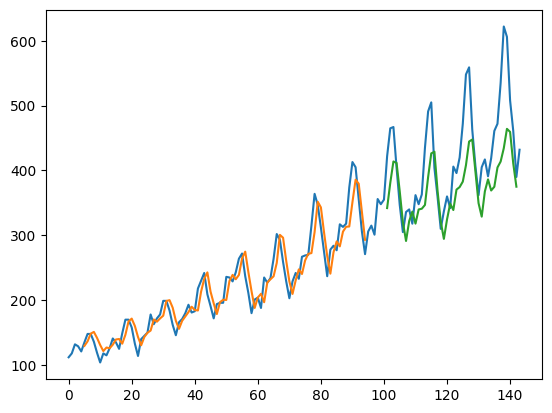

In [ ]:
look_back = 5
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)
# Download data
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df.index = df["Month"]
df = df.drop(columns=["Month"])
# Parse dataset
dataset = df.values
dataset = dataset.astype('float32')
# Get train/test data
trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back)
# Create the model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(4, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# See how the model did & generate predictions
trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)
# Plot predictions against reality
plot_results(model, dataset, trainPredict, testPredict)

Now we can play:


1.   Change look_back
2.   Change loss_function
3.   Change model architechture  return_sequences=True
4.   Make stateful stateful=True



Let's try with some financial data

In [ ]:
stock_df = pd.read_csv('https://raw.githubusercontent.com/Cal-Poly-Quant-Club/data/main/stock_data.csv', header=[0, 1], index_col=0)
stock_df

MSFT                                             \
                      close    high      low  trades    open    volume   
time                                                                     
2017-01-03 05:00:00   62.58   62.84   62.125  115077   62.80  23692973   
2017-01-04 05:00:00   62.30   62.75   62.120  112255   62.46  24383698   
2017-01-05 05:00:00   62.30   62.66   62.030  117581   62.18  27927285   
2017-01-06 05:00:00   62.84   63.15   62.040  111899   62.35  22359924   
2017-01-09 05:00:00   62.64   63.08   62.540   98825   62.67  24621963   
...                     ...     ...      ...     ...     ...       ...   
2024-03-04 05:00:00  414.92  417.35  412.320  397492  413.44  17595956   
2024-03-05 05:00:00  402.65  414.25  400.640  538264  413.96  26923077   
2024-03-06 05:00:00  402.09  405.16  398.390  449330  402.97  22344149   
2024-03-07 05:00:00  409.14  409.78  402.240  356886  406.12  18718479   
2024-03-08 05:00:00  406.22  410.42  404.330  371405  407.96  17981065   

                                       AAPL                    ...     SCHW  \
                    volume weighted   close      high     low  ...     open   
time                                                           ...            
2017-01-03 05:00:00       62.471587  116.15  116.3300  114.76  ...  1476.91   
2017-01-04 05:00:00       62.309944  116.02  116.5100  115.75  ...  1484.64   
2017-01-05 05:00:00       62.345968  116.61  116.8642  115.81  ...  1489.89   
2017-01-06 05:00:00       62.787132  117.91  118.1600  116.47  ...  1501.54   
2017-01-09 05:00:00       62.726351  118.99  119.4300  117.94  ...  1518.00   
...                             ...     ...       ...     ...  ...      ...   
2024-03-04 05:00:00      415.133115  175.10  176.9000  173.79  ...  3461.79   
2024-03-05 05:00:00      403.929173  170.12  172.0400  169.62  ...  3452.00   
2024-03-06 05:00:00      402.228118  169.12  171.2400  168.68  ...  3433.00   
2024-03-07 05:00:00      407.638384  169.00  170.7300  168.49  ...  3433.50   
2024-03-08 05:00:00      407.108610  170.73  173.7000  168.94  ...  3476.98   

                                               LRCX                          \
                     volume volume weighted   close    high      low trades   
time                                                                          
2017-01-03 05:00:00  487304     1472.249555   35.53   35.78   35.230  16061   
2017-01-04 05:00:00  409323     1489.490232   35.85   35.95   35.630  17676   
2017-01-05 05:00:00  467970     1498.772809   35.84   35.95   35.545  16516   
2017-01-06 05:00:00  490815     1519.543949   36.03   36.18   35.765  16041   
2017-01-09 05:00:00  418118     1532.048566   35.72   35.98   35.720  11833   
...                     ...             ...     ...     ...      ...    ...   
2024-03-04 05:00:00  270932     3477.935165  189.24  189.83  187.320  38801   
2024-03-05 05:00:00  287508     3435.284152  189.81  190.88  189.400  37795   
2024-03-06 05:00:00  236507     3423.577369  196.01  196.30  191.000  52389   
2024-03-07 05:00:00  270750     3465.486108  196.12  196.94  193.855  43012   
2024-03-08 05:00:00  305377     3487.496812  198.41  198.98  194.485  46353   

                                                      
                       open   volume volume weighted  
time                                                  
2017-01-03 05:00:00   35.74  3952455       35.494371  
2017-01-04 05:00:00   35.63  3207964       35.833027  
2017-01-05 05:00:00   35.93  2598827       35.791629  
2017-01-06 05:00:00   35.80  2332383       36.033033  
2017-01-09 05:00:00   35.98  2136122       35.786576  
...                     ...      ...             ...  
2024-03-04 05:00:00  187.76  2931044      188.806580  
2024-03-05 05:00:00  189.49  2445832      189.953737  
2024-03-06 05:00:00  193.40  3431512      194.966675  
2024-03-07 05:00:00  196.00  2964864      195.508831  
2024-03-08 05:00:00  195.13  2803518      197.641473  

[

Epoch 1/10
264/264 - 3s - loss: 0.0313 - 3s/epoch - 10ms/step
Epoch 2/10
264/264 - 1s - loss: 0.0100 - 785ms/epoch - 3ms/step
Epoch 3/10
264/264 - 1s - loss: 0.0040 - 788ms/epoch - 3ms/step
Epoch 4/10
264/264 - 1s - loss: 0.0011 - 615ms/epoch - 2ms/step
Epoch 5/10
264/264 - 1s - loss: 4.1939e-04 - 539ms/epoch - 2ms/step
Epoch 6/10
264/264 - 1s - loss: 3.5602e-04 - 513ms/epoch - 2ms/step
Epoch 7/10
264/264 - 1s - loss: 3.4673e-04 - 538ms/epoch - 2ms/step
Epoch 8/10
264/264 - 1s - loss: 3.5062e-04 - 517ms/epoch - 2ms/step
Epoch 9/10
264/264 - 1s - loss: 3.4602e-04 - 531ms/epoch - 2ms/step
Epoch 10/10
264/264 - 1s - loss: 3.2986e-04 - 520ms/epoch - 2ms/step
4/4 [==============================] - 0s 3ms/step
Train Score: 0.94 RMSE
Test Score: 2.91 RMSE


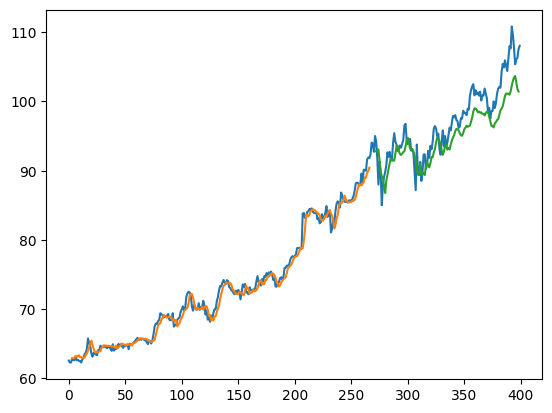

In [ ]:
# Download data
msft_df = stock_df["MSFT"][:400]
# Parse dataset
dataset = msft_df[["close"]].values
dataset = dataset.astype('float32')
look_back = 3
test_perc = 0.67
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

# Get train/test data
trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back, test_perc)
# Create the model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
# See how the model did & generate predictions
trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)
# Plot predictions against reality
plot_results(model, dataset, trainPredict, testPredict)

Epoch 1/10
938/938 - 4s - loss: 0.0380 - 4s/epoch - 4ms/step
Epoch 2/10
938/938 - 2s - loss: 0.0013 - 2s/epoch - 2ms/step
Epoch 3/10
938/938 - 2s - loss: 2.8297e-04 - 2s/epoch - 3ms/step
Epoch 4/10
938/938 - 2s - loss: 2.6570e-04 - 2s/epoch - 2ms/step
Epoch 5/10
938/938 - 2s - loss: 2.4880e-04 - 2s/epoch - 2ms/step
Epoch 6/10
938/938 - 2s - loss: 2.5166e-04 - 2s/epoch - 2ms/step
Epoch 7/10
938/938 - 2s - loss: 2.3970e-04 - 2s/epoch - 2ms/step
Epoch 8/10
938/938 - 2s - loss: 2.3145e-04 - 2s/epoch - 2ms/step
Epoch 9/10
938/938 - 3s - loss: 2.3169e-04 - 3s/epoch - 3ms/step
Epoch 10/10
938/938 - 2s - loss: 2.2538e-04 - 2s/epoch - 2ms/step
15/15 [==============================] - 0s 2ms/step
Train Score: 4.71 RMSE
Test Score: 10.79 RMSE


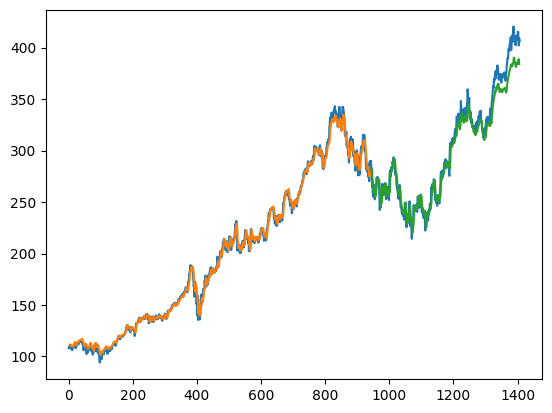

In [ ]:
# Picking up where we left off last time, with a validation step this time

# Download data
msft_df = stock_df["MSFT"][400:]
# Parse dataset
dataset = msft_df[["close"]].values
dataset = dataset.astype('float32')
look_back = 3
test_perc = 0.67
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

# Get train/test data
trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back, test_perc)
# Create the model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
# See how the model did & generate predictions
trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)
# Plot predictions against reality
plot_results(model, dataset, trainPredict, testPredict)

7/7 [==============================] - 0s 3ms/step


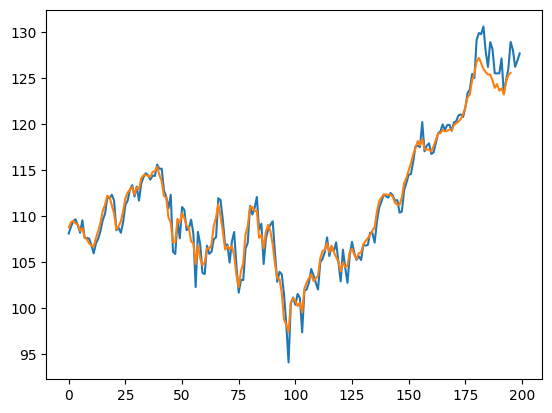

In [ ]:
# Let's try a validation test!

validation_df = stock_df["MSFT"][400:600]
validation_dataset = validation_df[["close"]].values
validation_dataset = validation_dataset.astype('float32')
norm_val = scaler.fit_transform(validation_dataset)
norm_valX, norm_valY = create_dataset(norm_val, look_back)
validation = np.reshape(norm_valX, (norm_valX.shape[0], 1, norm_valX.shape[1]))
validation_predictions = model.predict(validation)
validation_predictions = scaler.inverse_transform(validation_predictions)
plt.plot(validation_dataset)
plt.plot(validation_predictions)

# Weird that its still works?


# # shift train predictions for plotting
# trainPredictPlot = np.empty_like(normalized_dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(normalized_dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(normalized_dataset)-1, :] = testPredict

# # plot baseline and predictions
# plt.plot(dataset)
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

1/1 [==============================] - 0s 22ms/step


<ipython-input-26-131c80037f36>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  validation[0, 0, -1] = prediction


1/1 [==============================] - 0s 22ms/step


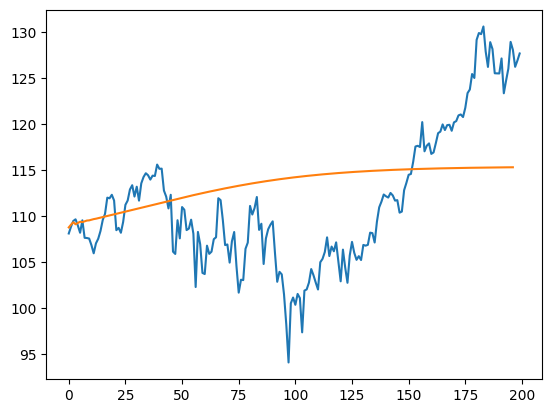

In [ ]:
#Time to talk about a walk forward test....

validation_df = stock_df["MSFT"][400:600]
validation_dataset = validation_df[["close"]].values
validation_dataset = validation_dataset.astype('float32')
norm_val = scaler.fit_transform(validation_dataset)
norm_valX, norm_valY = create_dataset(norm_val, look_back)

validation = np.reshape(norm_valX[0], (1, 1, look_back))

# Walk-forward testing
walk_forward_predictions = []
for _ in range(len(validation_dataset) - look_back):
    prediction = model.predict(validation)[0]
    walk_forward_predictions.append(prediction)
    # Shift the validation array to include the new prediction
    validation = np.roll(validation, -1, axis=-1)
    validation[0, 0, -1] = prediction

# Reshape predictions to match the scale
walk_forward_predictions = np.array(walk_forward_predictions).reshape(-1, 1)
walk_forward_predictions = scaler.inverse_transform(walk_forward_predictions)
plt.plot(validation_dataset)
plt.plot(walk_forward_predictions)

# Much better, we didn't actually create a model that predicts the stock market.

In [ ]:
# I kindof just lied to you. No one would really ever just let a model go off into obscurity without feeding it data

# Download data
msft_df = stock_df["MSFT"][:400]
# Parse dataset
dataset = msft_df[["close"]].values
dataset = dataset.astype('float32')
look_back = 3
test_perc = 0.5
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

# Get train/test data
trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back, test_perc)
# Create the model
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
# model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
# See how the model did & generate predictions

7/7 [==============================] - 0s 2ms/step
Train Score: 0.76 RMSE
Test Score: 1.86 RMSE
[[-22.230026]]
[28.739998]


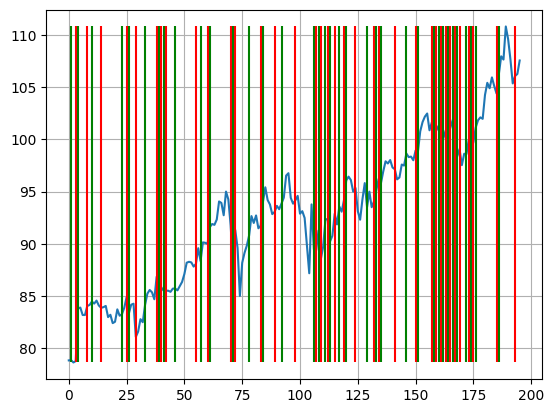

In [ ]:
trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)

difference = testPredict - np.roll(testPredict, 1)
# Calculate the signs of elements
signs = np.sign(difference)
# print(signs)
# Find where the sign changes (from -1 to 1 or 1 to -1)
change_points = np.diff(signs, axis=0)

decision_matrix = np.zeros_like(difference)
# Assign 1 to the position after change from negative to positive
decision_matrix[np.where(change_points == 2)[0] + 1] = 1

# Assign -1 to the position after change from positive to negative
decision_matrix[np.where(change_points == -2)[0] + 1] = -1
# print(decision_matrix)
aligned_dataset = dataset[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :]
profit = np.dot(decision_matrix.T, aligned_dataset)
print(profit)
print(aligned_dataset[-1] - aligned_dataset[0])
plt.plot(aligned_dataset)

for idx in range(len(decision_matrix)):
    if decision_matrix[idx] == 1:
        plt.vlines(idx, colors='green', ymin=min(aligned_dataset), ymax=max(aligned_dataset))
    elif decision_matrix[idx] == -1:
        plt.vlines(idx, colors='red', ymin=min(aligned_dataset), ymax=max(aligned_dataset))

plt.grid(True)
plt.show()

12/12 [==============================] - 0s 3ms/step
Train Score: 8.75 RMSE
Test Score: 34.37 RMSE
[[-309.81116]]
[978.80005]


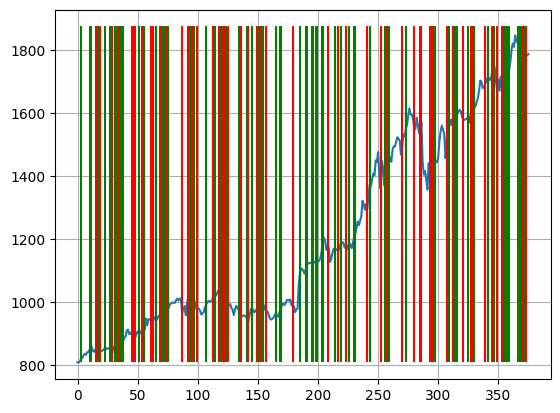

In [ ]:
# okay strange, what about just like an entierly different stock

# Doesn't work on google!, works on tesla though????
# Download data
msft_df = stock_df["AMZN"][:400]
# Parse dataset
dataset = msft_df[["open"]].values
dataset = dataset.astype('float32')
look_back = 3
test_perc = 0.05
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

# Get train/test data
trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back, test_perc)

trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)

difference = testPredict - np.roll(testPredict, 1)
# Calculate the signs of elements
signs = np.sign(difference)
# print(signs)
# Find where the sign changes (from -1 to 1 or 1 to -1)
change_points = np.diff(signs, axis=0)

decision_matrix = np.zeros_like(difference)
# Assign 1 to the position after change from negative to positive
decision_matrix[np.where(change_points == 2)[0] + 1] = 1

# Assign -1 to the position after change from positive to negative
decision_matrix[np.where(change_points == -2)[0] + 1] = -1
# print(decision_matrix)
aligned_dataset = dataset[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :]
profit = np.dot(decision_matrix.T, aligned_dataset)
print(profit)
print(aligned_dataset[-1] - aligned_dataset[0])
plt.plot(aligned_dataset)

for idx in range(len(decision_matrix)):
    if decision_matrix[idx] == 1:
        plt.vlines(idx, colors='green', ymin=min(aligned_dataset), ymax=max(aligned_dataset))
    elif decision_matrix[idx] == -1:
        plt.vlines(idx, colors='red', ymin=min(aligned_dataset), ymax=max(aligned_dataset))

plt.grid(True)
plt.show()


In [ ]:
# What...... lets try a lot of stocks and averaging

stocks = ["AAPL", "NVDA", "WMT", "HD", "META", "BRK", "LLY", "AVGO", "JPM"]
profits = []
buy_holds = []
for stock in stocks:
  msft_df = stock_df[stock][:400]
  # Parse dataset
  dataset = msft_df[["open"]].values
  dataset = dataset.astype('float32')
  look_back = 3
  test_perc = 0.05
  scaler = MinMaxScaler(feature_range=(0, 1))
  normalized_dataset = scaler.fit_transform(dataset)

  # Get train/test data
  trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back, test_perc)

  trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)

  difference = testPredict - np.roll(testPredict, 1)
  # Calculate the signs of elements
  signs = np.sign(difference)
  # print(signs)
  # Find where the sign changes (from -1 to 1 or 1 to -1)
  change_points = np.diff(signs, axis=0)

  decision_matrix = np.zeros_like(difference)
  # Assign 1 to the position after change from negative to positive
  decision_matrix[np.where(change_points == 2)[0] + 1] = 1

  # Assign -1 to the position after change from positive to negative
  decision_matrix[np.where(change_points == -2)[0] + 1] = -1
  # print(decision_matrix)
  aligned_dataset = dataset[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :]
  profit = np.dot(decision_matrix.T, aligned_dataset)
  buy_hold = aligned_dataset[-1] - aligned_dataset[0]
  print("Model", stock, profit)
  print("B&H", stock, buy_hold)
  buy_holds.append(buy_hold)
  profits.append(profit[0])

print(sum(profit)/len(stocks))
print(sum(buy_holds)/len(stocks))

12/12 [==============================] - 0s 3ms/step
Train Score: 0.75 RMSE
Test Score: 3.06 RMSE
Model AAPL [[149.87079]]
B&H AAPL [71.59]
12/12 [==============================] - 0s 2ms/step
Train Score: 2.32 RMSE
Test Score: 7.60 RMSE
Model NVDA [[-84.698]]
B&H NVDA [129.57999]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.65 RMSE
Test Score: 0.99 RMSE
Model WMT [[-0.57006836]]
B&H WMT [-3.6600037]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.27 RMSE
Test Score: 0.88 RMSE
Model HD [[-9.040016]]
B&H HD [6.6000023]
12/12 [==============================] - 0s 3ms/step
Train Score: 2.11 RMSE
Test Score: 4.07 RMSE
Model META [[-15.166168]]
B&H META [39.729996]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.91 RMSE
Test Score: 1.26 RMSE
Model BRK [[85.67106]]
B&H BRK [21.029999]
12/12 [==============================] - 0s 2ms/step
Train Score: 5.34 RMSE
Test Score: 5.95 RMSE
Model LLY [[61.937515]]
B&H LLY [8.12001]
12/12 [

In [ ]:
list(set(stock_df.columns.get_level_values(0).to_list()))

['ISRG',
 'LLY',
 'KO',
 'MS',
 'SYK',
 'GS',
 'XOM',
 'NVDA',
 'TSLA',
 'AMD',
 'CAT',
 'JNJ',
 'GE',
 'MA',
 'UBER',
 'NKE',
 'VZ',
 'NOW',
 'WFC',
 'AXP',
 'AAPL',
 'BRK',
 'ABBV',
 'MCD',
 'ADBE',
 'BX',
 'COP',
 'PM',
 'LOW',
 'LIN',
 'COST',
 'DHR',
 'META',
 'MSFT',
 'INTC',
 'AMAT',
 'PG',
 'NIKE',
 'SCHW',
 'SPGI',
 'AVGO',
 'ACN',
 'IBM',
 'CVX',
 'AMGN',
 'CSCO',
 'RTX',
 'HD',
 'NFLX',
 'PEP',
 'WMT',
 'TMO',
 'DIS',
 'BAC',
 'MRK',
 'QCOM',
 'US',
 'CMCSA',
 'PFE',
 'GOOG',
 'UNP',
 'INTU',
 'QUALCOMM',
 'TXN',
 'LRCX',
 'AMZN',
 'V',
 'UNH',
 'CRM',
 'TMUS',
 'MU',
 'NEE',
 'ORCL',
 'JPM',
 'HON',
 'ABT']

In [ ]:
# lets just try with the entire universe

# What...... lets try a lot of stocks and averaging

stocks = list(set(stock_df.columns.get_level_values(0).to_list()))
profits = []
buy_holds = []
for stock in stocks:
  try:
    msft_df = stock_df[stock][:400]
    # Parse dataset
    dataset = msft_df[["open"]].values
    dataset = dataset.astype('float32')
    look_back = 3
    test_perc = 0.05
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_dataset = scaler.fit_transform(dataset)

    # Get train/test data
    trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back, test_perc)

    trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)

    difference = testPredict - np.roll(testPredict, 1)
    # Calculate the signs of elements
    signs = np.sign(difference)
    # print(signs)
    # Find where the sign changes (from -1 to 1 or 1 to -1)
    change_points = np.diff(signs, axis=0)

    decision_matrix = np.zeros_like(difference)
    # Assign 1 to the position after change from negative to positive
    decision_matrix[np.where(change_points == 2)[0] + 1] = 1

    # Assign -1 to the position after change from positive to negative
    decision_matrix[np.where(change_points == -2)[0] + 1] = -1
    # print(decision_matrix)
    aligned_dataset = dataset[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :]
    profit = np.dot(decision_matrix.T, aligned_dataset)
    buy_hold = aligned_dataset[-1] - aligned_dataset[0]
    print("Model", stock, profit)
    print("B&H", stock, buy_hold)
    buy_holds.append(buy_hold)
    profits.append(profit[0])
  except:
    print("Failed on", stock)

print(sum(profit)/len(stocks))
print(sum(buy_holds)/len(stocks))

12/12 [==============================] - 0s 3ms/step
Train Score: 0.65 RMSE
Test Score: 1.68 RMSE
Model ISRG [[-22.864986]]
B&H ISRG [27.17]
12/12 [==============================] - 0s 2ms/step
Train Score: 5.34 RMSE
Test Score: 5.95 RMSE
Model LLY [[61.937515]]
B&H LLY [8.12001]
12/12 [==============================] - 0s 2ms/step
Train Score: 1.18 RMSE
Test Score: 1.29 RMSE
Model KO [[-21.501007]]
B&H KO [8.5]
12/12 [==============================] - 0s 2ms/step
Train Score: 3.02 RMSE
Test Score: 2.88 RMSE
Model MS [[-18.960266]]
B&H MS [28.460007]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.56 RMSE
Test Score: 1.02 RMSE
Model SYK [[-6.4423904]]
B&H SYK [10.450001]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.99 RMSE
Test Score: 1.12 RMSE
Model GS [[76.9639]]
B&H GS [11.120003]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.75 RMSE
Test Score: 3.16 RMSE
Model XOM [[-40.250107]]
B&H XOM [92.509995]
12/12 [============

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


12/12 [==============================] - 0s 2ms/step
Failed on TMO
12/12 [==============================] - 0s 2ms/step
Train Score: 1.09 RMSE
Test Score: 2.26 RMSE
Model DIS [[-38.309998]]
B&H DIS [44.230003]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.50 RMSE
Test Score: 0.61 RMSE
Model BAC [[1.1337938]]
B&H BAC [5.7]
12/12 [==============================] - 0s 2ms/step
Train Score: 1.23 RMSE
Test Score: 3.08 RMSE
Model MRK [[-16.039932]]
B&H MRK [46.83]
12/12 [==============================] - 0s 2ms/step
Train Score: 1.50 RMSE
Test Score: 1.08 RMSE
Model QCOM [[-4.975029]]
B&H QCOM [-0.02000046]
12/12 [==============================] - 0s 2ms/step
Train Score: 1.01 RMSE
Test Score: 3.49 RMSE
Model US [[-46.78003]]
B&H US [84.61]
12/12 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Failed on CMCSA
12/12 [==============================] - 0s 2ms/step
Train Score: 1.21 RMSE
Test Score: 2.20 RMSE
Model PFE [[-6.21994]]
B&H PFE [-15.260002]
12/12 [==============================] - 0s 2ms/step
Train Score: 9.63 RMSE
Test Score: 19.30 RMSE
Model GOOG [[-340.41992]]
B&H GOOG [406.49524]
12/12 [==============================] - 0s 2ms/step
Train Score: 15.52 RMSE
Test Score: 49.54 RMSE
Model UNP [[-353.43967]]
B&H UNP [-188.94998]
12/12 [==============================] - 0s 2ms/step
Train Score: 1.26 RMSE
Test Score: 0.62 RMSE
Model INTU [[-6.089982]]
B&H INTU [-16.51]
12/12 [==============================] - 0s 2ms/step
Train Score: 1.26 RMSE
Test Score: 3.07 RMSE
Model QUALCOMM [[116.510086]]
B&H QUALCOMM [44.26001]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.45 RMSE
Test Score: 0.43 RMSE
Model TXN [[35.18006]]
B&H TXN [7.619999]
12/12 [==============================] - 0s 2ms/step
Train Score: 0.41 RMSE
Test Score: 1.14 RMSE
Model LRCX [[-8.990